# Importing The libraries

In [1]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
images_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_path = "/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"

In [7]:
walker = os.walk(images_path)
first_iteration = next(walker, None)

if first_iteration is not None:
    img_ids = first_iteration[2]
else:
    img_ids = []
    print(f"No files found in {images_path}")

In [5]:
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]

In [6]:
images_path

'/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images'

In [ ]:
X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)

In [6]:
for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

In [7]:
for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

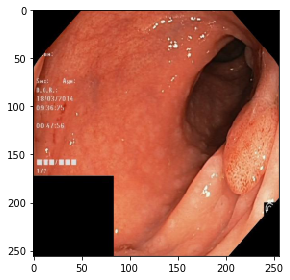

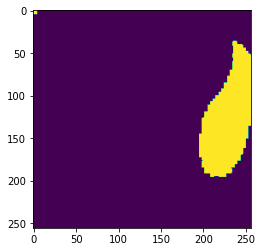

In [8]:
image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)


# MODEL:

## UNet model for image segmentation [Semantic].

[Paper](https://arxiv.org/abs/1505.04597)


In [11]:
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','iou_coef'])

In [12]:
# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])

model.summary()

Model: "U-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
______________________________________________________________________________________________

# Training the model.

In [14]:
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=100)

Epoch 1/100
76/76 [==============================] - 23s 141ms/step - loss: 0.7940 - accuracy: 0.8193 - iou_coef: 0.1024 - val_loss: 0.4813 - val_accuracy: 0.8206 - val_iou_coef: 0.1084
Epoch 2/100
76/76 [==============================] - 8s 111ms/step - loss: 0.4361 - accuracy: 0.8271 - iou_coef: 0.1239 - val_loss: 0.4166 - val_accuracy: 0.8206 - val_iou_coef: 0.1463
Epoch 3/100
76/76 [==============================] - 8s 112ms/step - loss: 0.4024 - accuracy: 0.8272 - iou_coef: 0.1490 - val_loss: 0.4312 - val_accuracy: 0.8206 - val_iou_coef: 0.1852
Epoch 4/100
76/76 [==============================] - 9s 113ms/step - loss: 0.3938 - accuracy: 0.8273 - iou_coef: 0.1594 - val_loss: 0.3841 - val_accuracy: 0.8218 - val_iou_coef: 0.1785
Epoch 5/100
76/76 [==============================] - 9s 114ms/step - loss: 0.3739 - accuracy: 0.8319 - iou_coef: 0.1835 - val_loss: 0.3950 - val_accuracy: 0.8242 - val_iou_coef: 0.1562
Epoch 6/100
76/76 [==============================] - 9s 115ms/step - loss:

## PREDICTED IMAGE:

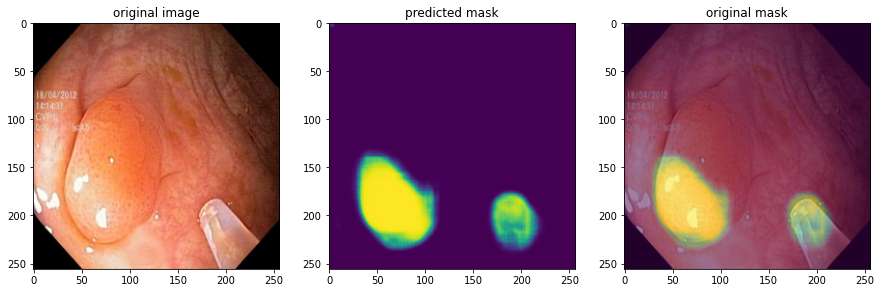

In [15]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.title("original image")
plt.imshow(np.squeeze(img))
plt.subplot(1, 3, 2)
plt.title("predicted mask")
plt.imshow(np.squeeze(predictions))
plt.subplot(1, 3, 3)
plt.title("original mask")
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.show()

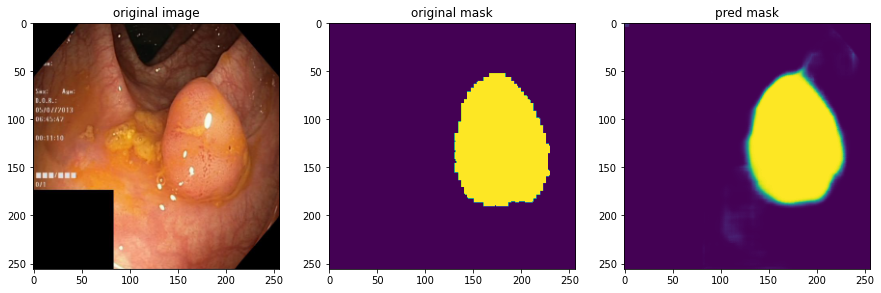

In [16]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
predMask = model.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image")
ax1.imshow(X_test[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask")
ax2.imshow(np.squeeze(y_test[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask")
ax3.imshow(np.squeeze(predMask))
